# Denoising Iris dataset + 96 N(0,1) attributes using *Clairvoyance*

The following tutorial uses the Iris dataset (n=150 samples, m=4 attributes, c=3 classes) with 96 N(0,1) distributed noise attributes.  Illustrates how to use *Clairvoyance* and how to interpret the output files.

In [119]:
# Import
import os,sys
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soothsayer as sy
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

## Dataset

In [102]:
# ==============
# Create dataset
# ==============
# Load in Iris dataset and add noise
X_iris, y_iris = sy.utils.get_iris_data(return_data=["X","y"], noise=96) #96 + 4 = 100 attributes

# Noise is N(0,1) so let's zscore normalize the actual iris data to keep the scales similar
X_iris.iloc[:,:4] = sy.transmute.normalize(X_iris.iloc[:,:4], method="zscore", axis=0)

# Get colors
chromatic_iris = sy.Chromatic.from_classes(y_iris, palette="Set2")

# Custom cross-validation pairs (not required)
K = 10
skf = StratifiedKFold(n_splits=K)
cv_data = defaultdict(dict)
for i, (idx_tr, idx_te) in enumerate(skf.split(X_iris, y_iris), start=1):
    label = "cv={}".format(i)
    cv_data[label]["Training"] = list(idx_tr)
    cv_data[label]["Testing"] = list(idx_te)
df_cv = pd.DataFrame(cv_data).T.loc[:,["Training", "Testing"]]

# Save the data

sy.io.write_dataframe(X_iris, "../Data/Iris/X_iris.noise_96.zscore.pbz2", create_directory_if_necessary=True) # This doesn't have to be a bz2 pickle object.  Just showing that it can work
sy.io.write_dataframe(y_iris.to_frame(), "../Data/Iris/y_iris.species.tsv.gz")
sy.io.write_dataframe(df_cv, "../Data/Iris/cv-with-labels.tsv")

## Visualize

Inferred mode as `dissimilarity`


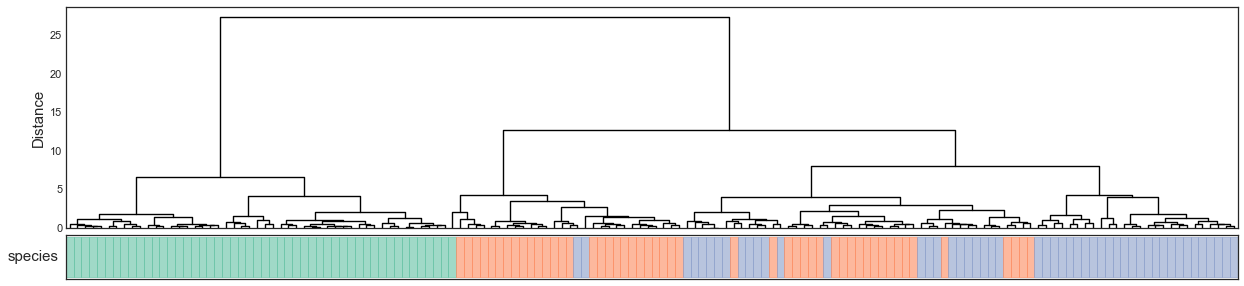

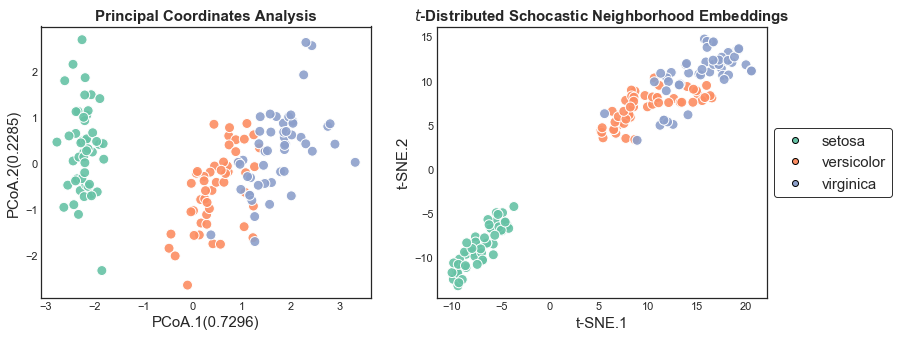

In [118]:
# =========================================
# Original Iris dataset (Zscore normalized)
# =========================================


# Symmetric pairwise distance matrix
df_dism = sy.symmetry.pairwise(X_iris.loc[:,['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], metric="euclidean", axis=0)

# Hierarchical clustering
ach_iris = sy.Agglomerative(df_dism,  name="iris")
ach_iris.add_secondary_class(name="species", mapping=y_iris, class_colors=chromatic_iris.class_colors)
ach_iris.plot()

# Ordination
with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(13,5), ncols=2)
    # Principal Coordinates Analysis
    pcoa_iris = sy.ordination.PrincipalCoordinatesAnalysis(df_dism)
    pcoa_iris.plot(c=chromatic_iris.obsv_colors,  title="Principal Coordinates Analysis", ax=axes[0])

    # t_SNE
    tsne_iris = sy.ordination.Manifold(df_dism)
    tsne_iris.plot(c=chromatic_iris.obsv_colors, legend=chromatic_iris.class_colors, title="$t$-Distributed Schocastic Neighborhood Embeddings", ax=axes[1])

Inferred mode as `dissimilarity`


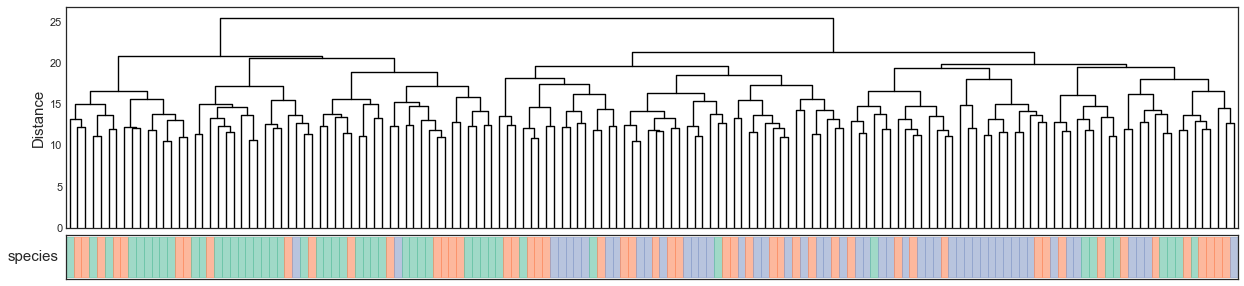

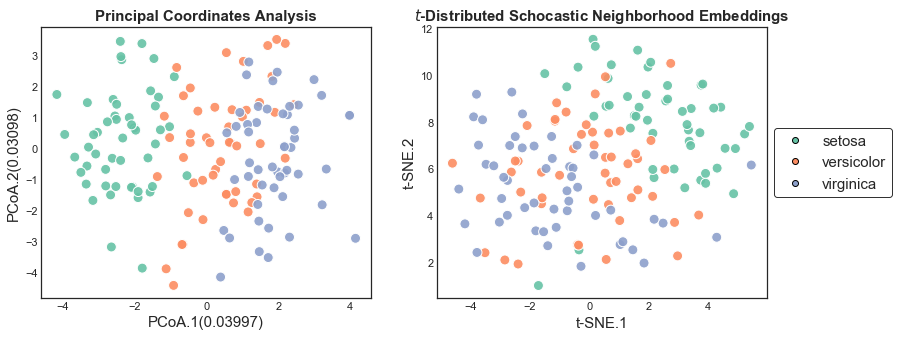

In [116]:
# =========================
# After adding N(0,1) noise
# =========================

# Symmetric pairwise distance matrix
df_dism = sy.symmetry.pairwise(X_iris, metric="euclidean", axis=0)

# Hierarchical clustering
ach_iris = sy.Agglomerative(df_dism, name="iris")
ach_iris.add_secondary_class(name="species", mapping=y_iris, class_colors=chromatic_iris.class_colors)
ach_iris.plot()

# Ordination
with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(13,5), ncols=2)
    # Principal Coordinates Analysis
    pcoa_iris = sy.ordination.PrincipalCoordinatesAnalysis(df_dism)
    pcoa_iris.plot(c=chromatic_iris.obsv_colors,  title="Principal Coordinates Analysis", ax=axes[0])

    # t_SNE
    tsne_iris = sy.ordination.Manifold(df_dism)
    tsne_iris.plot(c=chromatic_iris.obsv_colors, legend=chromatic_iris.class_colors, title="$t$-Distributed Schocastic Neighborhood Embeddings", ax=axes[1])

## Documentation for Clairvoyance

```bash
# run_soothsayer.py clairvoyance -h
usage: 
    soothsayer:clairvoyance v0.3_2018-08-28
     [-h]
                                                         [-X ATTRIBUTE_MATRIX]
                                                         [-y TARGET_VECTOR]
                                                         [-e ENCODING]
                                                         [--normalize NORMALIZE]
                                                         [-m MODEL_TYPE]
                                                         [--n_iter N_ITER]
                                                         [--random_state RANDOM_STATE]
                                                         [--n_jobs N_JOBS]
                                                         [--min_threshold MIN_THRESHOLD]
                                                         [--random_mode RANDOM_MODE]
                                                         [--percentiles PERCENTILES]
                                                         [-n NAME]
                                                         [-o OUT_DIR]
                                                         [--attr_type ATTR_TYPE]
                                                         [--class_type CLASS_TYPE]
                                                         [--method METHOD]
                                                         [--adaptive_range ADAPTIVE_RANGE]
                                                         [--adaptive_steps ADAPTIVE_STEPS]
                                                         [--cv CV]
                                                         [--min_bruteforce MIN_BRUTEFORCE]
                                                         [--early_stopping EARLY_STOPPING]
                                                         [--compression COMPRESSION]
                                                         [--pickled PICKLED]
                                                         [--save_kernel SAVE_KERNEL]
                                                         [--save_model SAVE_MODEL]
                                                         [--save_data SAVE_DATA]

optional arguments:
  -h, --help            show this help message and exit
  -X ATTRIBUTE_MATRIX, --attribute_matrix ATTRIBUTE_MATRIX
                        Input: Path/to/Tab-separated-value.tsv of attribute
                        matrix (rows=samples, cols=attributes)
  -y TARGET_VECTOR, --target_vector TARGET_VECTOR
                        Input: Path/to/Tab-separated-value.tsv of target
                        vector (rows=samples, column=integer target)
  -e ENCODING, --encoding ENCODING
                        Input: Path/to/Tab-separated-value.tsv of encoding.
                        Column 1 has enocded integer and Column 2 has string
                        representation. No header! [Default: None]
  --normalize NORMALIZE
                        Normalize the attribute matrix. Valid Arguments:
                        {'tss', 'zscore', 'quantile', None}: Warning, apply
                        with intelligence. For example, don't use total-sum-
                        scaling for fold-change values. [Experimental:
                        2018-May-03]
  -m MODEL_TYPE, --model_type MODEL_TYPE
                        Model types in ['logistic','tree'] represented by a
                        comma-separated list [Default: 'logistic,tree']
  --n_iter N_ITER       Number of iterations to split data and fit models.
                        [Default: 10]
  --random_state RANDOM_STATE
                        [Default: 0]
  --n_jobs N_JOBS       [Default: 1]
  --min_threshold MIN_THRESHOLD
                        Minimum accuracy for models when considering
                        coeficients for weights. Can be a single float or list
                        of floats separated by `,` ranging from 0-1. If None
                        it takes an aggregate weight. [Default: 0.0,None]
  --random_mode RANDOM_MODE
                        Random mode 0,1, or 2. 0 uses the same random_state
                        each iteration. 1 uses a different random_state for
                        each parameter set. 2 uses a different random_state
                        each time. [Default: 0]
  --percentiles PERCENTILES
                        Iterative mode takes in a comma-separated list of
                        floats from 0-1 that dictate how many of the
                        attributes will be used [Default:
                        0.0,0.3,0.5,0.75,0.9,0.95,0.96,0.97,0.98,0.99]
  -n NAME, --name NAME  Name for data [Default: Date]
  -o OUT_DIR, --out_dir OUT_DIR
                        Output: Path/to/existing-directory-for-output. Do not
                        use `~` to specify /home/[user]/ [Default: cwd]
  --attr_type ATTR_TYPE
                        Name of attribute type (e.g. gene, orf, otu, etc.)
                        [Default: 'attr']
  --class_type CLASS_TYPE
                        Name of class type (e.g. phenotype, MOA, etc.)
                        [Default: 'class']
  --method METHOD       {'adaptive', 'bruteforce'} [Default: 'bruteforce']
  --adaptive_range ADAPTIVE_RANGE
                        Adaptive range in the form of a string of floats
                        separated by commas [Default:'0.0,0.5,1.0']
  --adaptive_steps ADAPTIVE_STEPS
                        Adaptive stepsize in the form of a string of ints
                        separated by commas. len(adaptive_range) - 1
                        [Default:'1,10']
  --cv CV               Number of steps for percentiles when cross validating
                        and dropping attributes. If cv=0 then it skips cross-
                        validation step. [Default: 5]
  --min_bruteforce MIN_BRUTEFORCE
                        Minimum number of attributes to adjust to bruteforce.
                        If value is 0 then it will not change method [Default:
                        150]
  --early_stopping EARLY_STOPPING
                        Stopping the algorthm if a certain number of
                        iterations do not increase the accuracy. Use -1 if you
                        don't want to use `early_stopping` [Default: 100]
  --compression COMPRESSION
  --pickled PICKLED
  --save_kernel SAVE_KERNEL
                        Save the kernel [Default: True]
  --save_model SAVE_MODEL
                        Save the model [Default: False]
  --save_data SAVE_DATA
                        Save the model [Default: True]
```

In [14]:
%%bash
# ====================
# Running Clairvoyance
# ====================
X="../Data/Iris/X_iris.noise_96.zscore.pbz2"
y="../Data/Iris/y_iris.species.tsv.gz"
cv="../Data/Iris/cv-with-labels.tsv"
output_directory="../Data/Iris/Clairvoyance_Output"
mkdirs -p ${output_directory}
# Run algorithm
time(run_soothsayer.py clairvoyance -X ${X} -y ${y} -n iris -o ${output_directory} --cv ${cv} > ${output_directory}/clairvoyance.o)

bash: line 8: mkdirs: command not found
= == === ===== ======= ============ =====================
logistic
. .. ... ..... ....... ............ .....................
logistic | Percentile=0.0 | Permuting samples and fitting models: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]
logistic | Percentile=0.0 | X.shape = (150, 100) | Baseline score(../Data/Iris/X_iris.noise_96.zscore.pbz2) = 0.86667
logistic | CV | Percentile=0.0 | Minimum threshold=0.0: 100%|██████████| 99/99 [00:02<00:00, 46.63it/s]
logistic | CV | Percentile=0.0 | Minimum threshold=None: 100%|██████████| 99/99 [00:02<00:00, 45.33it/s]
logistic | Percentile=0.3 | Permuting samples and fitting models: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]
logistic | Percentile=0.3 | X.shape = (150, 70) | Baseline score(../Data/Iris/Clairvoyance_Output/logistic/percentile_0.3/X.subset.pbz2) = 0.86667
logistic | CV | Percentile=0.3 | Minimum threshold=0.0: 100%|██████████| 69/69 [00:01<00:00, 53.32it/s]
logistic | CV | Percentile=0.

## *Clairvoyance* Output

In [17]:
# Load in the synopsis (there are more intermediate files as well)
df_synopsis = sy.io.read_dataframe("../Data/Iris/Clairvoyance_Output/iris__synopsis/iris__synopsis.tsv")
# Check the accuracy for Logistic Regression and Decision Tree-based models
df_synopsis.groupby("model_type")["accuracy"].max()

model_type
logistic    0.960000
tree        0.966667
Name: accuracy, dtype: float64

In [24]:
# Check the accuracy of the models
for model_type, df in df_synopsis.groupby("model_type"):
    df = df.sort_values(["accuracy", "sem"], ascending=[False, True])
    print(sy.utils.format_header(model_type, "-"), df.iloc[0,:].drop(["baseline_score_of_current_percentile", "random_state", "delta"]), sep="\n")

--------
logistic
--------
model_type                                  logistic
hyperparameters          {'C': 1.0, 'penalty': 'l1'}
percentile                                       0.9
min_threshold                                      0
baseline_score                              0.866667
accuracy                                        0.96
sem                                        0.0147406
num_attr_included                                  2
attr_set             ['petal_width', 'petal_length']
Name: 8, dtype: object
----
tree
----
model_type                                                                         tree
hyperparameters      {'criterion': 'gini', 'min_samples_leaf': 3, 'max_features': None}
percentile                                                                         0.96
min_threshold                                                                         0
baseline_score                                                                 0.953333
accuracy          

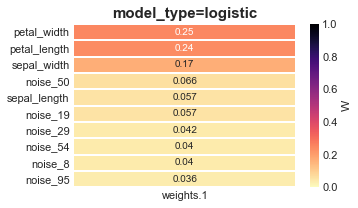

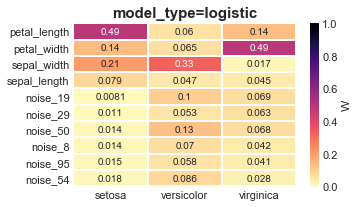

In [84]:
# =======================================
# Attribute weights (model_type=logisitc)
# =======================================

# Class agnostic weights
# ----------------------

W_logistic = sy.io.read_dataframe("../Data/Iris/Clairvoyance_Output/iris__synopsis/logistic__pctl_0.9__t_0.0__weights.tsv.gz")

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(W_logistic, vmin=0, vmax=1, cmap=plt.cm.magma_r, annot=True, cbar_kws={"label":"W"}, ax=ax, edgecolor="white", linewidth=1)
    ax.set_title("model_type=logistic", fontsize=15, fontweight="bold")
    ax.set_ylabel(None)

# Check that all weights sum to 1
assert np.allclose(W_logistic.sum(axis=0), 1)

# Class-specific weights
# ----------------------
W_logistic = sy.io.read_dataframe("../Data/Iris/Clairvoyance_Output/iris__synopsis/logistic__pctl_0.9__t_0.0__weights.class-specific.tsv.gz")

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(W_logistic, vmin=0, vmax=1, cmap=plt.cm.magma_r, annot=True, cbar_kws={"label":"W"}, ax=ax, edgecolor="white", linewidth=1)
    ax.set_title("model_type=logistic", fontsize=15, fontweight="bold")
    ax.set_ylabel(None)

# Check that all weights sum to 1
assert np.allclose(W_logistic.sum(axis=0), 1.0)

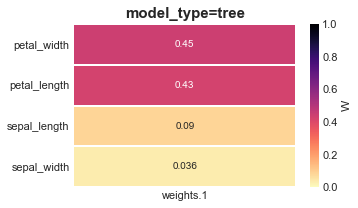

In [82]:
# =======================================
# Attribute weights (model_type=tree)
# =======================================

# Class agnostic weights
# ----------------------

W_tree = sy.io.read_dataframe("../Data/Iris/Clairvoyance_Output/iris__synopsis/tree__pctl_0.96__t_0.0__weights.tsv.gz")

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(W_tree, vmin=0, vmax=1, cmap=plt.cm.magma_r, annot=True, cbar_kws={"label":"W"}, ax=ax, edgecolor="white", linewidth=1)
    ax.set_title("model_type=tree", fontsize=15, fontweight="bold")
    ax.set_ylabel(None)

# Check that all weights sum to 1
assert np.allclose(W_tree.sum(axis=0), 1)

# # Class-specific weights
# # ----------------------
# # In future versions

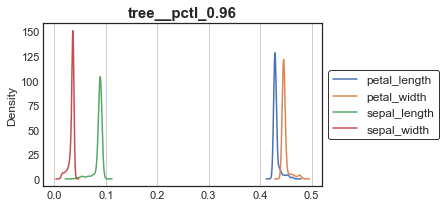

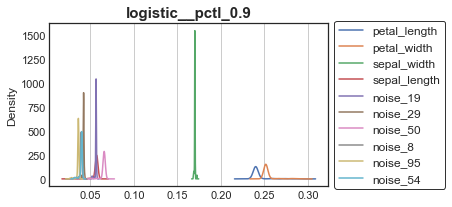

In [137]:
# Let's check the distribution of weights from the different thresholds at the "best" percentile
W_tree__distribution = sy.io.read_dataframe("../Data/Iris/Clairvoyance_Output/iris__synopsis/tree__pctl_0.96__weights.tsv.gz")
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    W_tree__distribution.plot(kind="kde", ax=ax)
    ax.set_title("tree__pctl_0.96", fontsize=15, fontweight="bold")
    ax.legend(**{ 'frameon': True, 'facecolor': 'white', 'edgecolor': 'black', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5), "fontsize":12})
    ax.xaxis.grid(True)


W_logistic__distribution = sy.io.read_dataframe("../Data/Iris/Clairvoyance_Output/iris__synopsis/logistic__pctl_0.9__weights.tsv.gz")
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    W_logistic__distribution.plot(kind="kde", ax=ax)
    ax.set_title("logistic__pctl_0.9", fontsize=15, fontweight="bold")
    ax.legend(**{ 'frameon': True, 'facecolor': 'white', 'edgecolor': 'black', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5), "fontsize":12})
    ax.xaxis.grid(True)



## Summary
The 96 noise features obscures the classes and creates an opportunity to illustrate the usage of *Clairvoyance*. 

From these parameters, we can see that Decision Trees slightly outperform Logistic Regression; though, the results are very similar.  

Despite the model type, we see the `petal_width` and `petal_length` are the most determinant features when discriminating the species.  